# Logistic Regression Notebook

In [1]:
# Non-modeling imports. Specific imports occur below.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Model related imports below
from sklearn.linear_model import LogisticRegression
# import zzz

In [3]:
# Import the data. Feel free to change this CSV.

df = pd.read_csv("ModelData/mbdata.csv")

In [4]:
df.shape[0]

1215

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='EvergreenFlag'),
                                                   df['EvergreenFlag'],test_size=.25,
                                                   random_state=1)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         save=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.show()

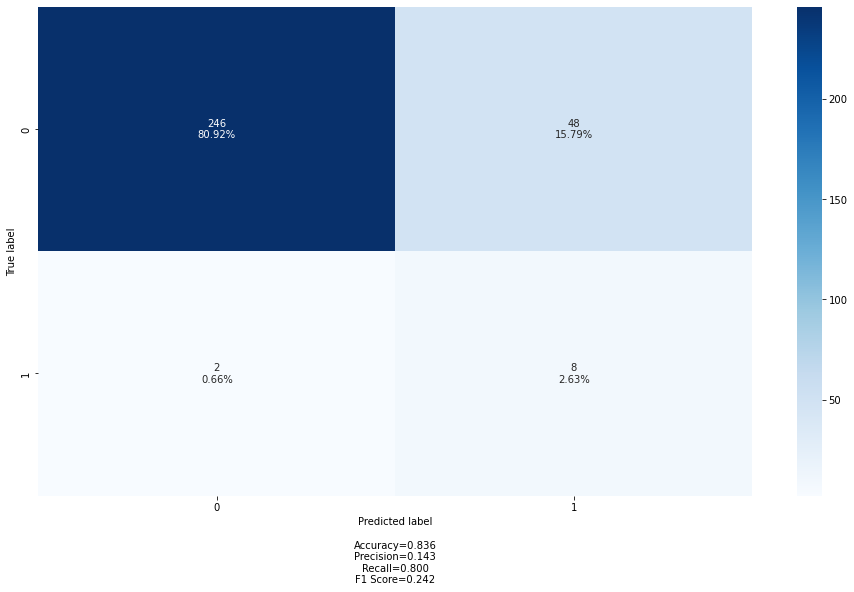

In [7]:
clf = LogisticRegression().fit(X_train,y_train)
predictions = clf.predict(X_test)
make_confusion_matrix(confusion_matrix(predictions,y_test),
                     figsize=(16,9))

In [8]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, cross_val_score


scoring = {
    'Accuracy' : make_scorer(accuracy_score),
    'Recall'   : make_scorer(recall_score)  
}
crossval = KFold(n_splits=4)
clf = LogisticRegression()

results = cross_val_score(estimator=clf,
                         X=df.drop(columns=['EvergreenFlag']),
                         y=df['EvergreenFlag'],
                         cv=crossval,
                         scoring=make_scorer(accuracy_score))

In [9]:
results.mean()

0.8049385530658328